In [1]:
from pydrake.all import StartMeshcat, MeshcatVisualizer, AddMultibodyPlantSceneGraph, HalfSpace, CoulombFriction, MeshcatVisualizerParams, ConstantValueSource, LogVectorOutput
import matplotlib.pyplot as plt
import numpy as np
import time
from pydrake.math import RigidTransform
from pydrake.all import DiagramBuilder, Simulator, Parser
from direct_col_dev import find_throwing_trajectory
from phase_switch import *
from osc import *
import pydot

### Parameters ###
file_name = "/home/dhruv/Hop-Skip-and-Jump/models/planar_walker.urdf"

# DIRCOL Parameters #
N = 10
jump_height = 0.5
tf = 1/2

# Robot Parameters #
initial_state = np.zeros(14)
q = np.zeros((7,))
q[0] = 0; q[1] = 0.95
theta = -np.arccos(q[1])
q[3] = theta; q[4] = -2 * theta
q[5] = theta;   q[6] = -2 * theta
initial_state[:7] = q
###            ###


### Designing the Simulator environment ###
meshcat = StartMeshcat()
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0005)
X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(plant.world_body(), X_WG, HalfSpace(), 
    "collision", CoulombFriction(1.0, 1.0))
parser = Parser(plant)
parser.AddModels(file_name)
plant.WeldFrames(plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity())
plant.Finalize()

### Direct Collocation ###
n_q = plant.num_positions()
n_v = plant.num_velocities()
n_u = plant.num_actuators()
x_traj, u_traj, prog,  _, _ = find_throwing_trajectory(N, initial_state, jump_height, tf=tf, jumpheight_tol=5e-2)
print("Direct Collocation Completed")

### Building the Diagram ###

#Connections 
OSC_Accesor = OSC(file_name)
PhaseSwitcher = builder.AddSystem(PhaseSwitch(jump_height, tf, x_traj, 0.4, file_name))
OScontroller = builder.AddSystem(OSC_Accesor)
logger = LogVectorOutput(OScontroller.GetOutputPort("logs"),builder)
builder.Connect(PhaseSwitcher.get_preflight_port_index(),OScontroller.get_preflightinput_port_index())
builder.Connect(PhaseSwitcher.get_aerial_trajectory_port_index(),OScontroller.get_flightinput_port_index())
builder.Connect(PhaseSwitcher.get_landing_trajectory_port_index(),OScontroller.get_landinginput_port_index())
builder.Connect(PhaseSwitcher.get_phase_switch_output_port_index(),OScontroller.get_phase_port_index())
builder.Connect(OScontroller.torque_output_port, plant.get_actuation_input_port())
builder.Connect(plant.get_state_output_port(), OScontroller.get_state_input_port()) 
builder.Connect(plant.get_state_output_port(), PhaseSwitcher.get_state_input_port()) 

#Builld
vis_params = MeshcatVisualizerParams(publish_period=0.005)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)
diagram = builder.Build()


INFO:drake:Meshcat listening for connections at http://localhost:7001


Starting the solve
optimal cost:  49390.24512964907
x_sol:  [[-0.000e+00  9.500e-01  0.000e+00 -3.200e-01  6.400e-01 -3.200e-01
   6.400e-01  0.000e+00 -0.000e+00 -0.000e+00  0.000e+00  0.000e+00
  -0.000e+00  0.000e+00]
 [-0.000e+00  9.400e-01  0.000e+00 -3.600e-01  7.200e-01 -3.900e-01
   7.600e-01 -5.000e-02 -3.400e-01 -7.000e-02 -2.680e+00  5.120e+00
  -5.230e+00  1.019e+01]
 [-0.000e+00  9.100e-01 -0.000e+00 -4.600e-01  9.200e-01 -6.800e-01
   1.350e+00 -2.000e-02 -9.000e-01  2.000e-02 -2.120e+00  4.230e+00
  -5.010e+00  9.770e+00]
 [-0.000e+00  8.400e-01  0.000e+00 -6.600e-01  1.280e+00 -9.000e-01
   1.760e+00 -3.000e-02 -1.450e+00 -2.000e-02 -5.070e+00  7.370e+00
  -2.290e+00  3.950e+00]
 [-0.000e+00  7.700e-01 -0.000e+00 -9.400e-01  1.620e+00 -1.030e+00
   1.990e+00  0.000e+00 -1.190e+00  4.000e-02 -2.820e+00  5.040e+00
  -4.550e+00  8.260e+00]
 [-0.000e+00  6.800e-01  0.000e+00 -1.110e+00  1.890e+00 -1.490e+00
   2.550e+00 -1.000e-02 -1.850e+00 -1.300e-01 -6.760e+00  8.970e+00

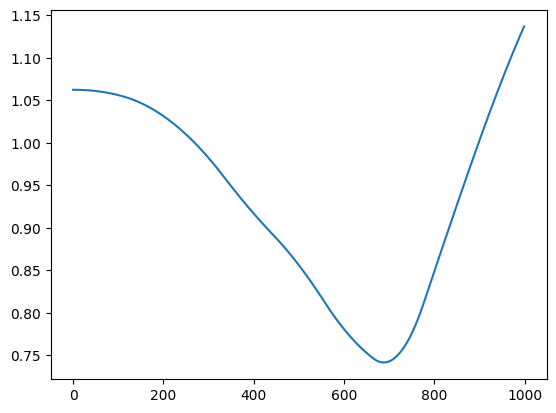

In [2]:
### Real Time Simulation ###
sim_time = tf+3
simulator = Simulator(diagram)
simulator.Initialize(); simulator.set_target_realtime_rate(0.1)
plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())
graph = (pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg())
with open('graph.svg', 'wb') as f:
    f.write(graph)

timesteps = np.linspace(0, tf, 1000)
com_pos_list = []
vel_list = []
for t in timesteps:
  x = x_traj.vector_values([t])
  u = np.linalg.norm(u_traj.vector_values([t]))
  plant.SetPositionsAndVelocities(plant_context, x)
  com_pos = plant.CalcCenterOfMassPositionInWorld(plant_context).ravel()
  com_pos_list.append(com_pos)

np.save('com.npy', np.array(com_pos_list))
plt.plot(np.array(com_pos_list)[:,2])


In [3]:
### Go ###
%tb
sim_time = tf+3
simulator = Simulator(diagram)
simulator.Initialize(); simulator.set_target_realtime_rate(1.5)
plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())
plant.SetPositionsAndVelocities(plant_context, initial_state)
simulator.AdvanceTo(tf+4)

No traceback available to show.


Solver not working, pal!!!   0.535
Solver not working, pal!!!   0.5355
Solver not working, pal!!!   0.536
Solver not working, pal!!!   0.5365
Solver not working, pal!!!   0.5375
Solver not working, pal!!!   0.538
Solver not working, pal!!!   0.5385
Solver not working, pal!!!   0.5485
Solver not working, pal!!!   0.549
Solver not working, pal!!!   0.5495
Solver not working, pal!!!   0.55


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
log = logger.FindLog(simulator.get_mutable_context()) #xyz vxvyvz
t = log.sample_times()
x = log.data()[:,1:]

COM_POS, COM_VEL, T_POS, T_VEL, left, right, COM_POS_DESIRED, COM_VEL_DESIRED, Torso_POS_DESIRED, Torso_VEL_DESIRED, Ft_POS_DESIRED, Ft_POS_DESIRED =  OSC_Accesor.logParse(x)

# Function to create subplots for 3D data
def plot_3d_data(ax, data, label, linestyle='-'):
    ax.plot(data[0, :], label=f'{label} - X', linestyle=linestyle)
    ax.plot(data[1, :], label=f'{label} - Y', linestyle=linestyle)
    ax.plot(data[2, :], label=f'{label} - Z', linestyle=linestyle)

# Create subplots
fig, axs = plt.subplots(6, 1, figsize=(10, 20))

# Plotting each pair of actual and desired values
plot_3d_data(axs[0], COM_POS, 'COM_POS')
plot_3d_data(axs[0], COM_POS_DESIRED, 'COM_POS_DESIRED', '--')
axs[0].set_title('Center of Mass Position')
axs[0].legend()

plot_3d_data(axs[1], COM_VEL, 'COM_POS')
plot_3d_data(axs[1], COM_VEL_DESIRED, 'COM_POS_DESIRED', '--')
axs[1].set_title('Center of Mass Velocity')
axs[1].legend()

axs[2].plot(T_POS[0], label = 'T_POS')
axs[2].plot(Torso_POS_DESIRED[0], label='Torso_POS_DESIRED', linestyle='--')
axs[2].set_title('Torso Position')
axs[2].legend()

axs[3].plot(T_VEL[0], label='T_VEL')
axs[3].plot(Torso_VEL_DESIRED[0], label='Torso_VEL_DESIRED', linestyle='--')
axs[3].set_title('Torso Velocity')
axs[3].legend()

plot_3d_data(axs[4], left, 'Left')
# plot_3d_data(axs[4], Ft_POS_DESIRED, 'Ft_POS_DESIRED', '--')
axs[4].set_title('Left and Desired Foot Position')
axs[4].legend()

plot_3d_data(axs[5], right, 'Right')
# plot_3d_data(axs[5], Ft_POS_DESIRED, 'Ft_POS_DESIRED', '--')
axs[5].set_title('Right and Desired Foot Position')
axs[5].legend()

plt.tight_layout()
plt.show()


KeyboardInterrupt: 